# *Hydraulic Systems Dataset*

Este *notebook* tem como objetivo identificar a condição de um trocador de calor responsável pela refrigeração do óleo de um sistema hidráulico. Para tanto, será utiliziado o conjunto de dados [*Condition Monitoring of Hydraulic Systems Dataset*](https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems), que contém registros de diversos sensores instalados em uma bancada hidráulica. Dentre a instrumentação, variáveis como pressão, temperatura, vazão, aceleração e potência são colhidas durante 60 segundos, tempo correspondente aos testes realizados.

Os experimentos consistiam de um sistema primário de trabalho e um sistema secundário de resfriamento e filtragem, ambos conectados por um reservatório de óleo. O sistema era submetido à cargas cíclicas de 60 segundos de duração. A cada ciclo, as variáveis do processo eram manipuladas com o intuito de variar a condição dos quatro componentes monitorados: trocador de calor, válvula, bomba e acumulador.

O *dataset* fornecido contém dados brutos dos sensores, com diferentes taxas de amostragem e organizados em forma matricial com separação por **tab**. Cada linha da matriz representa um determinado ciclo, enquanto as colunas representam uma coleta dentro dos 60 segundos de execução do teste. Cada arquivo representa um sensor específico:

| Sensor | Variável do processo | Unidade | Amostragem |
| :-: | :-: | :-: | :-: |
| PS1 | Pressão | bar | 100 hz |
| PS2 | Pressão | bar | 100 hz |
| PS3 | Pressão | bar | 100 hz |
| PS4 | Pressão | bar | 100 hz |
| PS5 | Pressão | bar | 100 hz |
| PS6 | Pressão | bar | 100 hz |
| EPS1 | Potência do motor | W | 100 hz |
| FS1 | Vazão | L/min | 10 hz |
| FS2 | Vazão | L/min | 10 hz |
| TS1 | Temperatura | ºC | 1 hz |
| TS2 | Temperatura | ºC | 1 hz |
| TS3 | Temperatura | ºC | 1 hz |
| TS4 | Temperatura | ºC | 1 hz |
| VS1 | Vibração | mm/s | 1 hz |
| CE | Eficiência do resfriamento | % | 1 hz |
| CP | Potência virtual do resfriamento | kW | 1 hz |
| SE | Fator de eficiência | % | 1 hz |

Os rótulos, por sua vez, estão contidos em um arquivo a parte e, como as *features*, estão organizados de forma que as linhas representam o número do ciclo e as colunas as condições monitoradas. São elas:

| Condição do trocador de calor [%] | Condição da válvula [%] | Vazamento interno da válvula | Acumulador hidráulico [bar] | Condição de estabilidade |
| :-: | :-: | :-: | :-: | :-: |
| 3: próximo da falha catastrófica | 73: próximo da falha catastrófica | 0: sem vazamento | 90: próximo da falha catastrófica | 0: condições estavam estáveis |
| 20: eficiência reduzida; | 80: lag severo | 1: pouco vazamento | 100: redução severa de pressão | 1: condições estáticas talvez não tenham sido alcançadas |
| 100: eficiência completa. | 90: lag baixo | 2: vazamento severo | 115: baixa redução de pressão | - |
| - | 100: condição ótima | - | 130: pressão ótima | - |

Embora o conjunto de dados apresentado possua informação que possibilite a identificação da condição de todos os componentes monitorados durante os testes, a solução aqui apresentada, como já comentado, será direcionada para a identificação da condição do *cooler*.

![hydroSystem](./img/hydroSystem.png)


# Importações

In [1]:
# Ferramentas matemáticas
import numpy as np
import pandas as pd

# ferramentas de visualização
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# utilitários
from hydro_utils import process, plots, models
from sklearn.model_selection import train_test_split

# Carregamento dos dados

In [2]:
# carregamento dos dados após upsampling
data, labels = process.load_hydroSystem('./datasets/hydro/')

Carregamento dos conjuntos de dados:


100%|██████████| 18/18 [00:23<00:00,  1.32s/it]


Processamento dos dados:


100%|██████████| 2205/2205 [00:10<00:00, 209.13it/s]


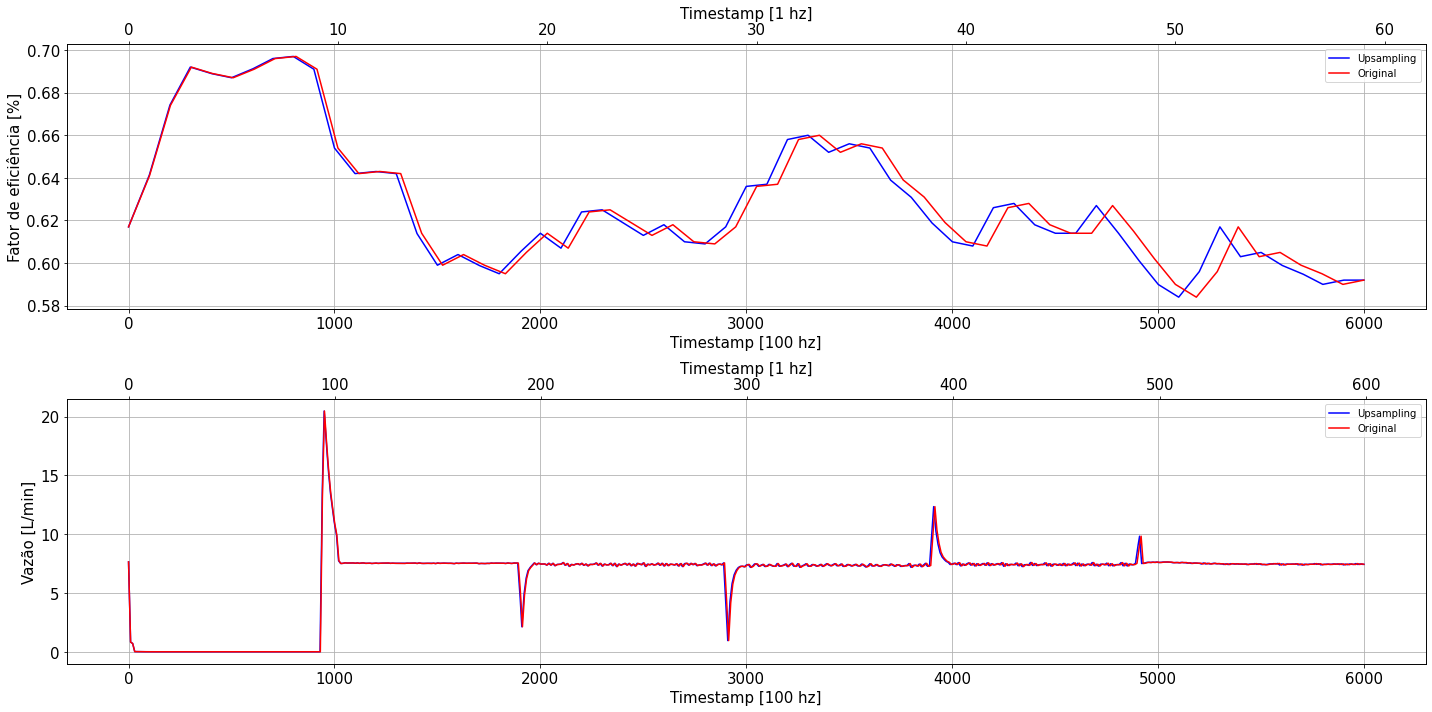

In [3]:
# Comparação entre os dados tratados e os dados originais, em relação à frequência de amostragem
plots.compare_data(data)

# Análise exploratória dos dados

In [4]:
# Análise dos sinais
plots.timeplots(data, labels)

Devido à dependência dos sinais dos sensores e o experimento que originou os registros, a análise exploratória dos dados é muito dificultada. Embora o comportamento dos sinais possa ser avaliado em alguns experimentos, como realizado de forma aleatória, não se pode generalizar tais comportamentos, uma vez que o mesmo pode variar de experimento para experimento. Todavia, algumas expectativas podem ser criadas. Primeiramente, alguns sensores aparentam apresentar valores muito distintos para as três condições existentes no conjunto de dados, tais como PS5, PS6, FS2, TS1, TS2, TS3, TS4, CE e CP.

Como uma forma de visualizar o conjunto de dados com mais facilidade, opta-se por condensar os dados em um Pandas DataFrame. A identificação do experimento se dá por meio de uma coluna específica. Dessa forma, os dados que até então se apresentavam por um tensor de 3 dimesões, passa a ser um DataFrame tradicional. O processamento pode ser acessado em utils.process.create_df.

In [5]:
tab_data = process.create_hydrodf(data, labels)
tab_data

100%|██████████| 2205/2205 [09:26<00:00,  3.89it/s]


PS1     PS2    PS3     PS4     PS5    PS6    FS1      FS2       TS1  \
0     151.47  125.50  2.305   0.000   9.936  9.818  8.990  10.1790  35.57000   
1     151.45  125.39  2.305   0.000   9.947  9.823  8.168  10.1785  35.56922   
2     151.52  125.40  2.336   0.000   9.964  9.844  7.346  10.1780  35.56844   
3     151.27  125.03  2.578   0.000   9.989  9.861  6.524  10.1775  35.56766   
4     150.80  124.05  2.977   0.000   9.996  9.877  5.702  10.1770  35.56688   
...      ...     ...    ...     ...     ...    ...    ...      ...       ...   
5995  151.64  125.73  2.305  10.204   9.989  9.870  7.774  10.1760  35.42600   
5996  151.70  125.81  2.320  10.238  10.007  9.882  7.774  10.1760  35.42600   
5997  151.73  125.77  2.273  10.223  10.007  9.886  7.774  10.1760  35.42600   
5998  151.71  125.66  2.227  10.218   9.988  9.870  7.774  10.1760  35.42600   
5999  151.70  125.77  2.250  10.212   9.964  9.854  7.774  10.1760  35.42600   

           TS2       TS3       TS4    EPS1      VS1        CE     CP  \
0     40.96100  38.32000  30.36300  2411.6  0.60400  47.20200  2.184   
1     40.96088  38.32012  30.36312  2411.6  0.60401  47.20271  2.184   
2     40.96076  38.32024  30.36324  2411.6  0.60402  47.20342  2.184   
3     40.96064  38.32036  30.36336  2411.6  0.60403  47.20413  2.184   
4     40.96052  38.32048  30.36348  2411.6  0.60404  47.20484  2.184   
...        ...       ...       ...     ...      ...       ...    ...   
5995  40.89100  38.18700  30.37500  2416.2  0.53100  46.62100  2.148   
5996  40.89100  38.18700  30.37500  2416.6  0.53100  46.62100  2.148   
5997  40.89100  38.18700  30.37500  2416.8  0.53100  46.62100  2.148   
5998  40.89100  38.18700  30.37500  2417.0  0.53100  46.62100  2.148   
5999  40.89100  38.18700  30.37500  2417.0  0.53100  46.62100  2.148   

            SE   exp  condition  
0     68.03900     1          3  
1     67.35861     1          3  
2     66.67822     1          3  
3     65.99783     1          3  
4     65.31744     1          3  
...        ...   ...        ...  
5995  68.11700  2205        100  
5996  68.11700  2205        100  
5997  68.11700  2205        100  
5998  68.11700  2205        100  
5999  68.11700  2205        100  

[13230000 rows x 19 columns]

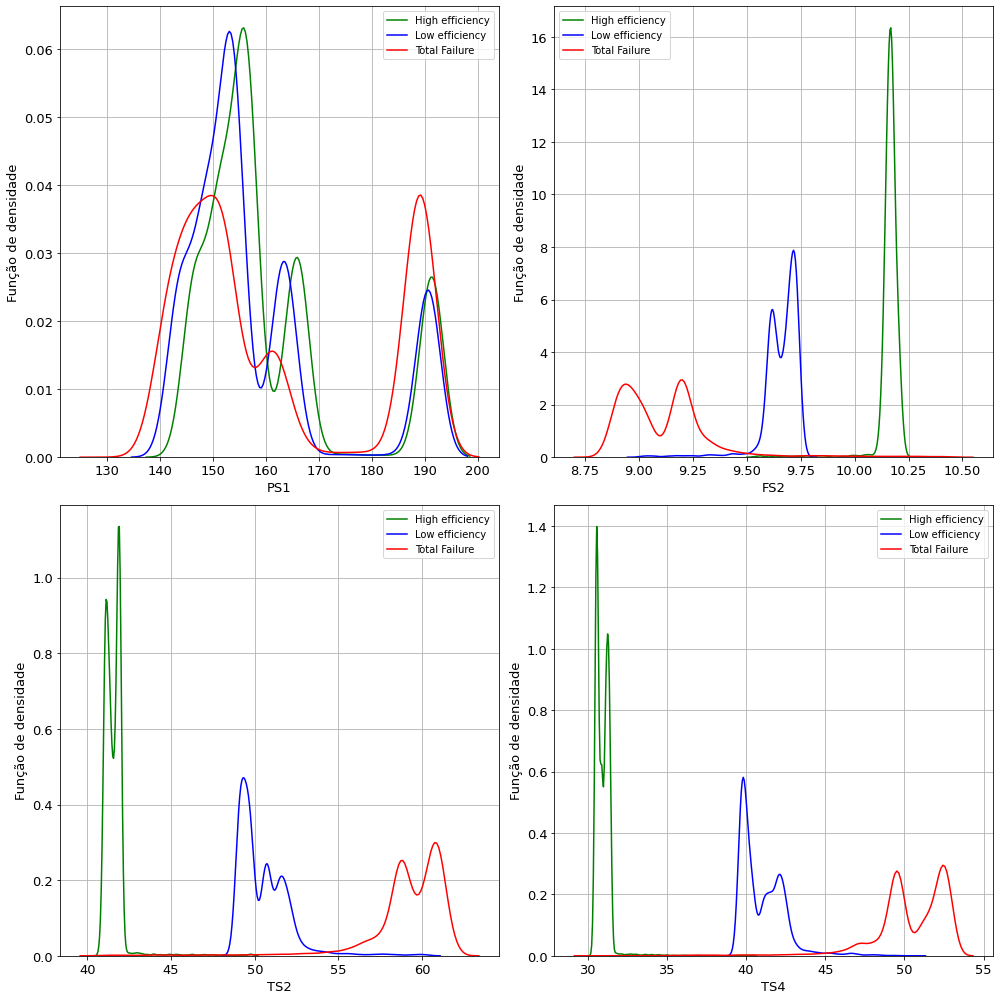

In [6]:
# distribuição dos dados
plots.dist_plot(tab_data, sensors=['PS1', 'FS2', 'TS2', 'TS4'])

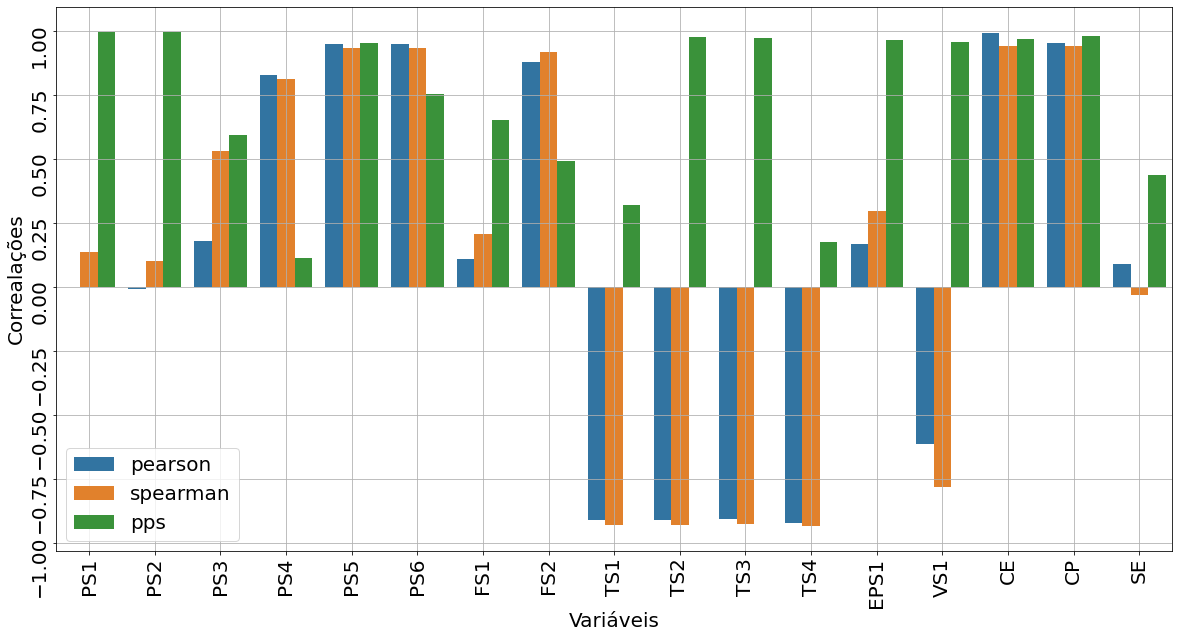

In [7]:
plots.corr_plot(tab_data)

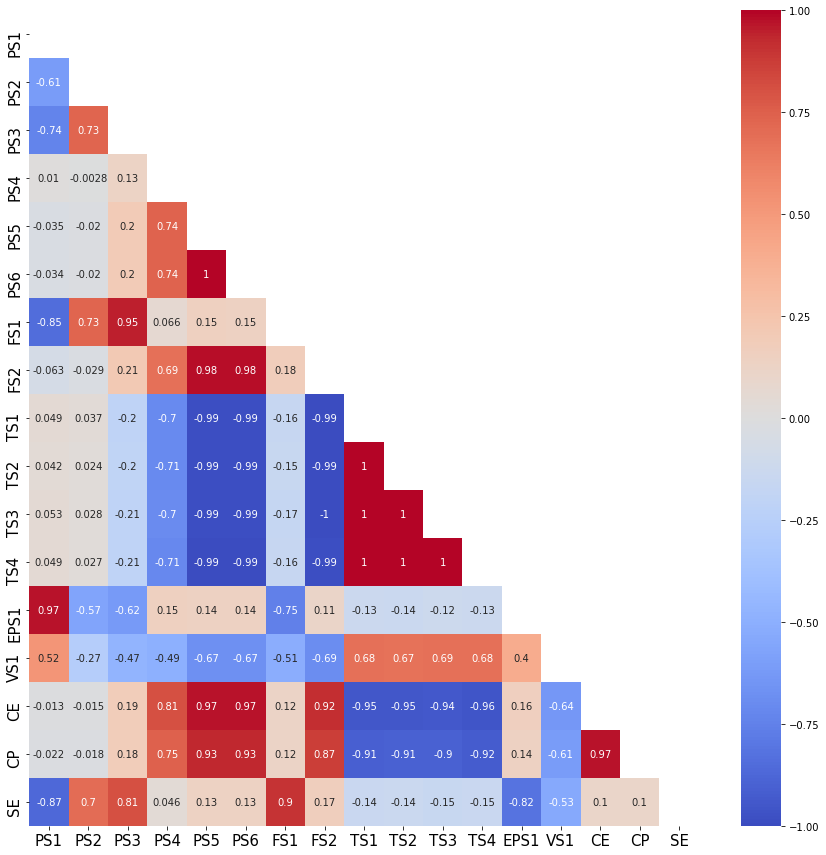

In [8]:
plots.redundant_features(tab_data)

## Modelo *baseline*

In [9]:
# verificação de um modelo baseline
model = models.baseline_model(31, 52)
model.report(tab_data['TS4'], tab_data['condition'])

              precision    recall  f1-score   support

           3       1.00      0.35      0.52   4392000
          20       0.48      1.00      0.65   4392000
         100       1.00      0.56      0.72   4446000

    accuracy                           0.64  13230000
   macro avg       0.83      0.64      0.63  13230000
weighted avg       0.83      0.64      0.63  13230000



# Pré Processamento

In [10]:
# identificação das variáveis redundantes e dos sensores que participam do circuito de resfriamento
red_feat = ['PS6', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'EPS1', 'CE', 'CP']
cooler_line_feat = ['PS4', 'PS5']

# criação das colunas que serão excluidas
dropped_cols = np.r_[red_feat, cooler_line_feat]
tab_cols = pd.Series(tab_data.drop(columns=['exp', 'condition']).columns)
selected_index = tab_cols[~tab_cols.isin(dropped_cols)].index

# seleção do conjunto visado
processed_data = data[:, :, selected_index]

[]

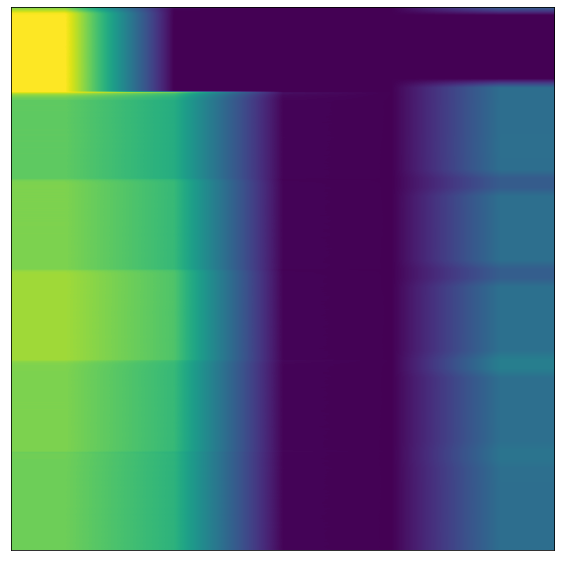

In [11]:
# separação em conjunto de treino e teste
train_x, test_x, train_y, test_y = train_test_split(processed_data, labels, test_size=.2, random_state=42)

# visualização da entrada do modelo
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv2.resize(train_x[0], (800,800)))
ax.set_xticks([])
ax.set_yticks([])


In [12]:
train_y.values[1]

100

# Treinamento do modelo

In [13]:
# criação e treinamento do modelo
rf_cls = models.RF_classifier(random_state=42)
rf_cls.train(train_x, train_y)

NameError: name 'importlib' is not defined

## Avaliação do modelo

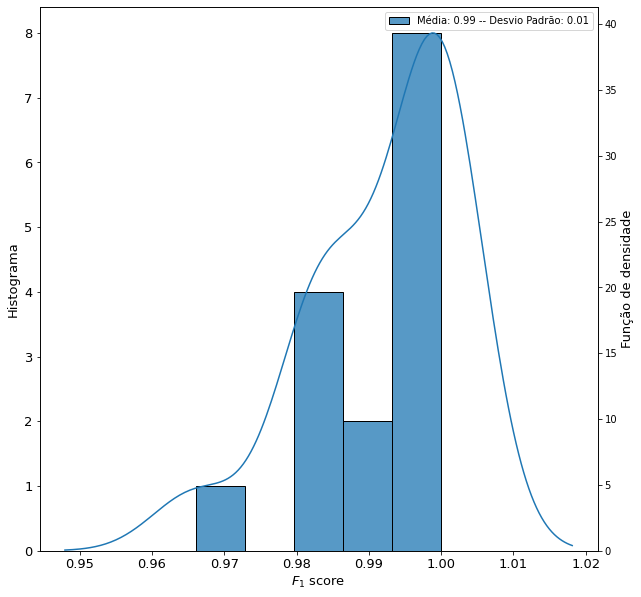

In [ ]:
# Cross validation do modelo
rf_cls.report(train_x, train_y, cross=True)

In [ ]:
# performance no conjunto de testes
rf_cls.report(test_x, test_y)

              precision    recall  f1-score   support

           3       0.97      1.00      0.99       152
          20       1.00      1.00      1.00       135
         100       1.00      0.97      0.99       154

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441

